# Importación de librerías

In [64]:
import numpy as np
import pandas as pd
import os
import csv
import random
import _pickle as pickle
from PIL import Image
from skimage.transform import resize

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras import layers
from keras.models import load_model

import matplotlib.pyplot as plt

# Carga de Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Lectura de los datos

In [3]:
# Carga de los dataframes de train, test y validation
df_train = pd.read_csv("/content/drive/MyDrive/TFM/data/EfficientNetB0/train_labels.csv")
df_test = pd.read_csv("/content/drive/MyDrive/TFM/data/EfficientNetB0/test_labels.csv")
df_validation = pd.read_csv("/content/drive/MyDrive/TFM/data/EfficientNetB0/validation_labels.csv")

print("El número de registros en df_train es: " + str(len(df_train)))
print("El número de registros en df_test es: " + str(len(df_test)))
print("El número de registros en df_validation es: " + str(len(df_validation)))

El número de registros en df_train es: 32072
El número de registros en df_test es: 3000
El número de registros en df_validation es: 3000


In [4]:
df_train.head()

,PatientId,Target
0,ba8f8cb0-5aed-4242-b117-8516f4c7b51b,0
1,49f5c9f1-8c3c-4afc-b940-33e1500d31e8,0
2,0cc27255-7f78-4093-84d7-04190a7d72ec,0
3,a12b6a40-323c-4ead-8875-5b84ae4beb6f,0
4,de94813d-0475-41b0-b248-af03dfb5a412,0


In [5]:
df_test.head()

,PatientId,Target
0,a74b7b44-ae2b-48cc-bc0a-597d221a4d08,0
1,da0483cc-6cd4-40c5-aaef-b085a01cd76c,0
2,7658ef50-d386-4066-92d9-5d5735af5f3c,0
3,922fa0c4-f867-4102-9741-5952a84c3fee,0
4,cab1fcd3-7e67-4928-8612-80bae540ca2c,0


In [6]:
df_validation.head()

,PatientId,Target
0,6a2d8b64-cf13-47e2-bed9-41a6b801e1fb,1
1,97a6f7c7-df3f-4127-907d-27823c48f2fe,1
2,b434200b-248e-4aa3-aeff-b0c9351a65fc,1
3,9abdc28f-151f-4243-8595-1751a8ad1286,0
4,bf88dd53-1b28-44b4-b101-33b49816d8a0,0


## Comprobación de los datos

Vamos a comprobar que las imágenes que se encuentran en cada directorio, es decir, en train, validation, y test, también están en los dataframes correspondientes.

Se hace esta comprobación básicamente para saber si se han subido de forma correcta las imágenes.

In [7]:
def check_images(dir, df):
  files = os.listdir(dir)
  num_elements = len(df)
  num_images = len(files)

  # Recorremos el dataframe correspondiente y comprobamos si están las imágenes
  for patientId in df["PatientId"]:
    if not patientId + ".png" in files:
      return False

  # Comprobamoos que hay el mismo número de registros que de imágenes
  if num_elements != num_images:
    return False

  return True

In [9]:
print("Train: " + str(check_images("/content/drive/MyDrive/TFM/data/EfficientNetB0/train_images", df_train)))
print("Test: " + str(check_images("/content/drive/MyDrive/TFM/data/EfficientNetB0/test_images", df_test)))
print("Validation: " + str(check_images("/content/drive/MyDrive/TFM/data/EfficientNetB0/validation_images", df_validation)))

Train: True
Test: True
Validation: True


# Carga de las imágenes preprocesadas

En este punto vamos a cargar todas las imágenes que tenemos en un diccionario, es decir, tanto las imágenes de train, como de test y validation.

Este diccionario está formado por un par clave-valor, donde la clave va a ser el `PatientId` (el nombre de la imágenes sin el ".png"), y el valor va a ser la imágenes preprocesada en formato 224x224 (neceario para hacer uso de EfficientNetB0).

Se ha hecho uso de esta carga en un diccionario para reducir los tiempos de ejecución en el entrenamiento de la red, ya que anteriormente el Data Generator tardaba demasiado por dos motivos:
* Al abrir la imagen en cada época.
* Al redimensionar la imagen del formato original 1024x1024 a 224x224.

In [10]:
# EXTRA
TRAIN_FOLDER = "/content/drive/MyDrive/TFM/data/EfficientNetB0/train_images"
TEST_FOLDER = "/content/drive/MyDrive/TFM/data/EfficientNetB0/test_images"
VALID_FOLDER = "/content/drive/MyDrive/TFM/data/EfficientNetB0/validation_images"

MODEL_NAME = "model4/"

In [ ]:
def get_dic_images(dir, dic_images):
  files = os.listdir(dir)
  dic = dic_images.copy()

  for filename in files:
    patientId = filename.split(".")[0]
    image = np.array(Image.open(os.path.join(dir, filename)))
    dic[patientId] = image
  
  return dic

In [ ]:
dic_images = {}
dic_images = get_dic_images(TRAIN_FOLDER, dic_images)
dic_images = get_dic_images(TEST_FOLDER, dic_images)
dic_images = get_dic_images(VALID_FOLDER, dic_images)

In [ ]:
# Volcamos los datos a un fichero
pickle.dump(dic_images, open(os.path.join("/content/drive/MyDrive/TFM/data/EfficientNetB0", "dic_images.pickle"), 'wb'))

Para no tener que cargar todo el rato el diccionario, ya que esto es muy costoso (estar abriendo cada imagen), hemos el diccionario a un fichero pickle.

De esta forma, conseguimos reducir el tiempo de carga de las imágenes. Finalmente, definimos la carga en el caso de ser necesaria: 

In [11]:
# Hacemos la lectura de los datos
dic_images = pickle.load(open(os.path.join("/content/drive/MyDrive/TFM/data/EfficientNetB0", "dic_images.pickle"), "rb"))

# Comprobamos que se ha hecho la lectura de forma correcta
print("El número total de imágenes es: " + str(len(dic_images)))
print("El número total de imágenes esperadas es: " + str(len(df_train) + len(df_test) + len(df_validation)))

El número total de imágenes es: 38072
El número total de imágenes esperadas es: 38072


# Data Generator

En este punto vamos a resolver la problemática de la carga de los datos en memoria. El dataset de entrenamiento presenta 32072 imágenes con resolución 224x224, lo cual hace que haya un elevado consumo de memoria, hasta tal punto que puede que Google Colab no sea capaz de soportar.

Para solventar este problema creamos un data generator, el cual se encarga de cargar en memoria pequeños grupos de imágenes según se vayan utilizando, es decir, dependiendo del tamaño del batch.

La salida que proporciona el data generator es un cojunto de imágenes junto con la variable objetivo.

Cabe destacar que al usar EfficientNet la imagen de entrada a la red tiene que tener valores entre 0 y 255, es por ello que no se normalizan los datos porque EfficientNet ya tiene sus layers para hacerlo.


In [12]:
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class DataGenerator(keras.utils.Sequence):

  # Constructor
  def __init__(self, folder, dataset, dic_images, batch_size=32, image_size=256, shuffle=True, predict=False):
    self.folder = folder
    self.filenames = os.listdir(folder)
    self.dataset = dataset
    self.dic_images = dic_images.copy()
    self.batch_size = batch_size
    self.image_size = image_size
    self.shuffle = shuffle
    self.predict = predict
    self.on_epoch_end()
    

  # Carga y Transformación de la imágenes para training
  # filename: es el nombre del archivo de la imagen, es decir, con png
  def __train__(self, filename):
    filename = filename.split(".")[0]

    # Cargamos la imagen original
    img = self.dic_images[filename]

    # Cargamos la variable objetivo
    target = self.dataset[self.dataset["PatientId"] == filename]["Target"].item()

    # Reducción de la escala de la imagen
    if (self.image_size, self.image_size) != (IMG_SIZE, IMG_SIZE): 
      img = resize(img, (self.image_size, self.image_size), mode="reflect") * 255
      img = img.astype(np.uint8)

    # Normalizamos
    # img_min = img.min()
    # img_max = img.max()
    # img_norm = (img - img_min) / (img_max - img_min)

    # Expandimos las dimensiones (self.image_size, self.image_size, 1)
    # img_norm = np.expand_dims(img_norm, -1)
    img = np.expand_dims(img, -1)

    return img, target


  # Carga y transformación de las imágenes para testing
  def __test__(self, filename):
    filename = filename.split(".")[0]

    # Cargamos la imagen original
    img = self.dic_images[filename]

    # Reducción de la escala de la imagen
    if (self.image_size, self.image_size) != (IMG_SIZE, IMG_SIZE): 
      img = resize(img, (self.image_size, self.image_size), mode="reflect") * 255
      img = img.astype(np.uint8)

    # Normalizamos
    # img_min = img.min()
    # img_max = img.max()
    # img_norm = (img - img_min) / (img_max - img_min)

    # Expandimos las dimensiones (self.image_size, self.image_size, 1)
    # img_norm = np.expand_dims(img_norm, -1)
    img = np.expand_dims(img, -1)

    return img

  
  # Método encargado de generar el batch
  def __getitem__(self, index):
    # Generación de los nombres de archivos pertenecientes al batch
    filenames_batch = self.filenames[index*self.batch_size:(index+1)*self.batch_size]

    if self.predict:
      # Modo testing
      imgs = [self.__test__(filename) for filename in filenames_batch]
      imgs = np.array(imgs)
      return imgs, filenames_batch

    else:
      # Modo training
      items = [self.__train__(filename) for filename in filenames_batch]
      imgs, targets = zip(*items)
      imgs = np.array(imgs)
      targets = np.expand_dims(np.array(targets), -1)
      return imgs, targets

  # Método encargado de mezclar nos nombres de archivos, para así dotar de una mayor aleatoriedad
  def on_epoch_end(self):
    if self.shuffle:
      random.shuffle(self.filenames)

  # Método para controlar el tamaño del 
  def __len__(self):
    return int(len(self.filenames) / self.batch_size)

# Red Neuronal Convolucional

El siguiente paso es crear la red neuronal convolucional, para ello vamos a hacer uso de `EfficientNet`, en nuestro caso usaremos `EfficientNetB0`.

Al usar `EfficientNetB0` estamos "limitados" a que la resolución de las imágenes sea de 224x224, en vez de 1024x1024 que era el tamaño original.

Otro punto a destacar es que la imagen que introduzcamos al modelo no hace falta normalizarla, ya que se encarga `EfficientNetB0` de hacerlo.

## Hiperparámetros

In [13]:
# Data generator
IMG_SIZE = 224
BATCH_SIZE = 32

# CNN
NUM_CLASSES = 2
LEARNING_RATE = 1e-3
EPOCHS = 15 # 20, 30, 50, 30

## Data augmentation

El siguiente punto es definir el data augmentation, para así mejorar la variabilidad del entrenamiento y por lo tanto la precisión de la red neuronal.

In [35]:
img_augmentation = Sequential(
    [
     layers.RandomRotation(factor=0.05),
     layers.RandomTranslation(height_factor=0.05, width_factor=0.02),
     layers.RandomFlip("horizontal"),
     layers.RandomContrast(factor=0.05),
    ],
    name = "img_augmentation"
)

## CNN y transfer learning

El siguiente paso es crear la red neuronal convolucional y aplicar transefer learning.

El transfer learning lo que significa es que vamos a tener dos modelos, un modelo base con pesos ya pre-entrenados con otro tipo de problemas, y un modelo nuevo basado en el modelo base.

De forma resumida lo que se va a hacer es lo siguiente:
* 1º: vamos a inicializar el modelo base con pesos ya pre-entrenados.
* 2º: se van a congelar todos los layers del modelo base con `trainable = False`.
* 3º: Creamos un nuevo modelo después de la salida del modelo base.
* 4º: Entrenamos el nuevo modeloo con el dataset.

In [15]:
# Método que se encarga de generar el modelo
# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/#transfer-learning-from-pretrained-weights
# https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images
def build_model():
  inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
  x = img_augmentation(inputs)
  x = layers.Concatenate()([x, x, x])  
  model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

  # Freeze the pretrained weights
  model.trainable = False

  # Rebuild top
  x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
  x = layers.BatchNormalization()(x)

  top_dropout_rate = 0.2
  x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
  # outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)
  outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)

  # Compile
  model = keras.Model(inputs, outputs, name="EfficientNet")
  optimizer = Adam(learning_rate=LEARNING_RATE)
  model.compile(
      optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
  )
  return model

## Training

In [16]:
# Obtenemos los generadores para training y validaton
train_gen = DataGenerator(folder=TRAIN_FOLDER, dataset=df_train, dic_images=dic_images, batch_size=BATCH_SIZE, image_size=IMG_SIZE, shuffle=True, predict=False)
valid_gen = DataGenerator(folder=VALID_FOLDER, dataset=df_validation, dic_images=dic_images, batch_size=BATCH_SIZE, image_size=IMG_SIZE, shuffle=False, predict=False)

In [17]:
# Construimos el modelo (tanto el modelo base como el nuestro)
model = build_model()

16719872/16705208 [==============================] - 0s 0us/step


In [18]:
# Entrenamos la red
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=EPOCHS,
)

Epoch 1/30
1002/1002 [==============================] - 122s 105ms/step - loss: 0.5147 - accuracy: 0.7562 - val_loss: 0.4816 - val_accuracy: 0.7792
Epoch 2/30
1002/1002 [==============================] - 105s 105ms/step - loss: 0.4709 - accuracy: 0.7785 - val_loss: 0.4697 - val_accuracy: 0.7826
Epoch 3/30
1002/1002 [==============================] - 105s 105ms/step - loss: 0.4663 - accuracy: 0.7821 - val_loss: 0.5085 - val_accuracy: 0.7782
Epoch 4/30
1002/1002 [==============================] - 106s 106ms/step - loss: 0.4652 - accuracy: 0.7842 - val_loss: 0.4869 - val_accuracy: 0.7792
Epoch 5/30
1002/1002 [==============================] - 102s 102ms/step - loss: 0.4657 - accuracy: 0.7843 - val_loss: 0.4823 - val_accuracy: 0.7819
Epoch 6/30
1002/1002 [==============================] - 102s 102ms/step - loss: 0.4620 - accuracy: 0.7851 - val_loss: 0.5014 - val_accuracy: 0.7866
Epoch 7/30
1002/1002 [==============================] - 102s 102ms/step - loss: 0.4603 - accuracy: 0.7854 - val_

## Guardado del modelo

Antes de evaluar a nivel visual el modelo vamos a guardarlo:

In [19]:
# Guardamos el modelo
model_save_path = "/content/drive/MyDrive/TFM/models/EfficientNetB0/" + MODEL_NAME + "model_" + "EP" + str(EPOCHS) + "_" + "LR" + str(LEARNING_RATE) + "_" + "BS" + str(BATCH_SIZE) + '.pickle'
model.save(model_save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TFM/models/EfficientNetB0/model4/model_EP30_LR0.001_BS32.pickle/assets


In [20]:
# Guardamos el history del modelo
pickle.dump(history.history, open(os.path.join("/content/drive/MyDrive/TFM/models/EfficientNetB0/" + MODEL_NAME, "history.pickle"), 'wb'))

## Visualización de la pérdida y de la precisión

In [21]:
# Visualizamos la evolución de la accuracy
def show_accuracy(history):
  fig, axis = plt.subplots(figsize=(8,5))
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='lower right')
  plt.show()

# Visualizamos la evolución del error cometido por la red
def show_loss(history):
  fig, axis = plt.subplots(figsize=(8,5))
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

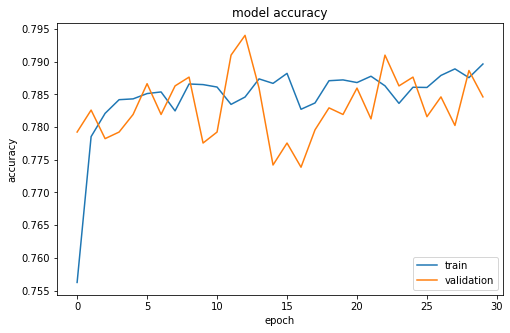

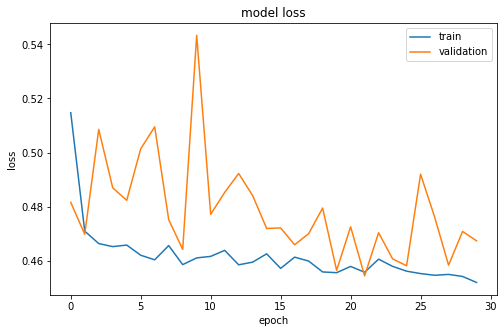

In [22]:
show_accuracy(history.history)
show_loss(history.history)

# Fine-tuning

Una vez tenemos el red neuronal entrenada procedemos a mejorar la precisión de la misma, para ello vas a realizar lo técnica que se conoce como "fine-tuning".

El objetivo Fine-tuning es mejorar la precisión del modelo a partir de "descongelar" cierto número de layers del modelo base y usar un learning rate más pequeño.

## Hiperparámetros

In [74]:
# CNN
LEARNING_RATE_FT = 1e-4 # 1e-4, 1e-5
EPOCHS_FT = 10 # 15, 10, 15

## CNN y Fine-tuning

In [75]:
def unfreeze_model(model):
  # Freeze the pretrained weights
  # for layer in model.layers[-38:]:
  for layer in model.layers:
    if not isinstance(layer, layers.BatchNormalization):
      layer.trainable = True

  # Compile
  optimizer = Adam(learning_rate=LEARNING_RATE_FT)
  model.compile(
      optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
  )
  return model

In [40]:
# def unfreeze_model(model):
#   for layer in model.layers[-20:]:
#       if not isinstance(layer, layers.BatchNormalization):
#           layer.trainable = True

#   optimizer = Adam(learning_rate=LEARNING_RATE_FT)
#   model.compile(
#       optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
#   )

# def unfreeze_model():
#   inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
#   x = img_augmentation(inputs)
#   x = layers.Concatenate()([x, x, x])  
#   model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

#   # Freeze the pretrained weights
#   for layer in model.layers[:-38]:
#     layer.trainable = False

#   # Rebuild top
#   x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
#   x = layers.BatchNormalization()(x)

#   top_dropout_rate = 0.2
#   x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
#   outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)

#   # Compile
#   model = keras.Model(inputs, outputs, name="EfficientNet")
#   optimizer = Adam(learning_rate=LEARNING_RATE_FT)
#   model.compile(
#       optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
#   )
#   return model

## Training

In [77]:
model = load_model("/content/drive/MyDrive/TFM/models/EfficientNetB0/model1/model_EP20_LR0.001_BS32.pickle")

In [78]:
# Descongelamos layers del modelo base
model = unfreeze_model(model)

In [79]:
# Entrenamos la red
history_ft = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=EPOCHS_FT,
)

Epoch 1/10
1002/1002 [==============================] - 262s 253ms/step - loss: 0.3900 - accuracy: 0.8259 - val_loss: 0.4610 - val_accuracy: 0.7920
Epoch 2/10
1002/1002 [==============================] - 246s 245ms/step - loss: 0.3272 - accuracy: 0.8547 - val_loss: 0.4312 - val_accuracy: 0.7967
Epoch 3/10
1002/1002 [==============================] - 247s 247ms/step - loss: 0.3003 - accuracy: 0.8664 - val_loss: 0.4531 - val_accuracy: 0.8128
Epoch 4/10
1002/1002 [==============================] - 245s 244ms/step - loss: 0.2839 - accuracy: 0.8724 - val_loss: 0.4718 - val_accuracy: 0.8098
Epoch 5/10
1002/1002 [==============================] - 247s 246ms/step - loss: 0.2737 - accuracy: 0.8791 - val_loss: 0.4300 - val_accuracy: 0.8249
Epoch 6/10
1002/1002 [==============================] - 245s 245ms/step - loss: 0.2604 - accuracy: 0.8843 - val_loss: 0.3643 - val_accuracy: 0.8384
Epoch 7/10
1002/1002 [==============================] - 247s 247ms/step - loss: 0.2555 - accuracy: 0.8878 - val_

## Guardado del modelo

In [27]:
# Guardamos el modelo
model_ft_save_path = "/content/drive/MyDrive/TFM/models/EfficientNetB0/" + MODEL_NAME + "model_ft" + "EP" + str(EPOCHS_FT) + "_" + "LR" + str(LEARNING_RATE_FT) + "_" + "BS" + str(BATCH_SIZE) + '.pickle'
model.save(model_ft_save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TFM/models/EfficientNetB0/model4/model_ftEP15_LR1e-05_BS32.pickle/assets


In [28]:
# Guardamos el history del modelo
pickle.dump(history_ft.history, open(os.path.join("/content/drive/MyDrive/TFM/models/EfficientNetB0/" + MODEL_NAME, "history_ft.pickle"), 'wb'))

## Visualización de la pérdida y de la precisión

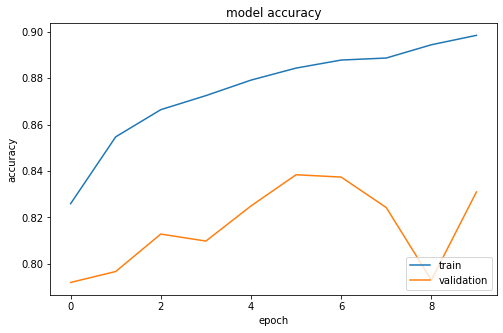

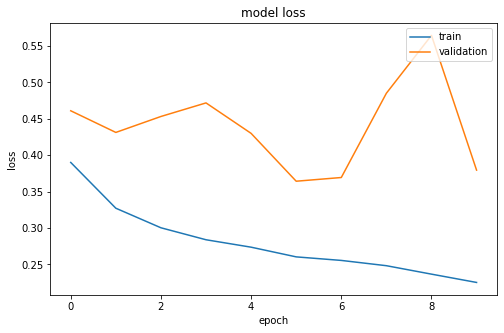

In [80]:
show_accuracy(history_ft.history)
show_loss(history_ft.history)

# Evaluación del modelo

Evaluación del modelo a partir de la matriz de confusión y del informe de clasificación:

In [81]:
# Obtenermos el generador para test
test_gen = DataGenerator(folder=TEST_FOLDER, dataset=df_test, dic_images=dic_images, batch_size=BATCH_SIZE, image_size=IMG_SIZE, shuffle=False, predict=True)

In [97]:
# Calculamos las predicciones para cada batch
y_test = []
y_preds = []
y_probs = []

for images, filenames in test_gen:
  y_preds_batch = model.predict(images)

  for y_pred, filename in zip(y_preds_batch, filenames):
    y_test.append(df_test[df_test["PatientId"] == filename.split(".")[0]]["Target"].item())
    y_probs.append(y_pred)
    if y_pred < 0.5:
      y_preds.append(0)
    else:
      y_preds.append(1)

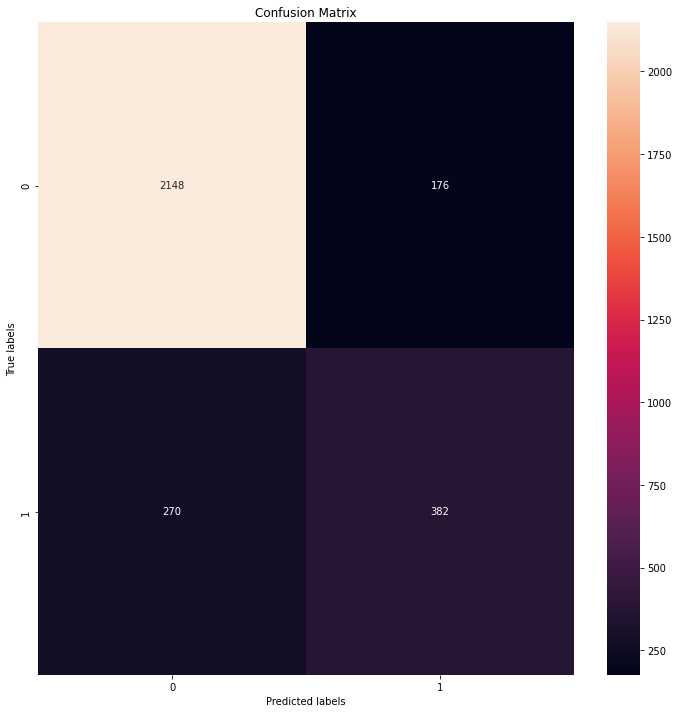



La precisión: 85.01 %


In [98]:
# Matriz de confusión
matrix = confusion_matrix(y_test, y_preds)

# Visualización de la matriz de confusión
# https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12))
sns.heatmap(matrix, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(np.unique(y_preds)))
ax.yaxis.set_ticklabels(list(np.unique(y_preds)))
plt.show()

#Accuracy
accuracy = 0
for i in range(matrix.shape[0]):
  accuracy += matrix[i,i]
accuracy = accuracy / sum(sum(matrix))
print("\n\nLa precisión: " + str(round(accuracy * 100, 2)) + " %")

In [85]:
#Precision, Recall and F1-score
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91      2324
           1       0.68      0.59      0.63       652

    accuracy                           0.85      2976
   macro avg       0.79      0.76      0.77      2976
weighted avg       0.84      0.85      0.85      2976



Text(0.5, 1.0, 'Lung Opacity ROC Curve')

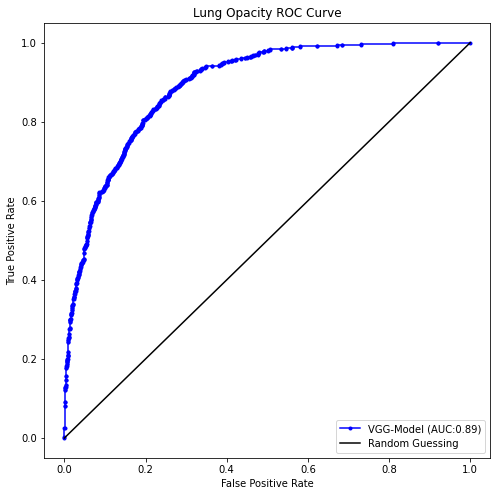

In [103]:
fpr, tpr, _ = roc_curve(y_test, y_probs)
fig, ax1 = plt.subplots(1,1, figsize = (8, 8))
ax1.plot(fpr, tpr, 'b.-', label = 'VGG-Model (AUC:%2.2f)' % roc_auc_score(y_test, y_probs))
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
ax1.set_title('Lung Opacity ROC Curve')

In [34]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 img_augmentation (Sequential)  (None, 224, 224, 1)  0           ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 224, 224, 3)  0           ['img_augmentation[0][0]',       
                                                                  'img_augmentation[0][0]',       
                                                                  'img_augmentation[0][